# Modelo de Regresión Lineal para Predicción de Prima de Seguro Médico

Este cuaderno implementa un flujo de trabajo completo de aprendizaje automático para predecir la variable **"prima_out_of_pocket_editada"** utilizando un modelo de Regresión Lineal. El flujo incluye:

- Carga y preprocesamiento de datos
- Ingeniería de características
- Entrenamiento y evaluación del modelo
- Visualización de curvas de aprendizaje e importancia de variables
- Guardado del modelo entrenado
- Búsqueda de hiperparámetros

In [13]:
# Carga de datos y preprocesamiento
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Cargar el conjunto de datos plano
print("Cargando el conjunto de datos...")
df = pd.read_csv('../snapshots_flat.csv')

# Identificar columnas categóricas
columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Columnas categóricas detectadas: {columnas_categoricas}")

# Aplicar one-hot encoding a las variables categóricas
if columnas_categoricas:
    df = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)
    print("One-hot encoding aplicado a variables categóricas.")
else:
    print("No se detectaron columnas categóricas.")

# Imputar valores faltantes (NaN) con la media
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Definir variables predictoras y objetivo
X = df_imputed.drop('prima_out_of_pocket_editada', axis=1)
y = df_imputed['prima_out_of_pocket_editada']

# Dividir en conjuntos de entrenamiento y prueba
print("Dividiendo los datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}, Tamaño de prueba: {X_test.shape}")

Cargando el conjunto de datos...
Columnas categóricas detectadas: ['sexo', 'raza_etnicidad', 'estado_civil', 'region', 'categoria_pobreza', 'cobertura_seguro', 'estado_salud_percibido', 'cobertura_seguro_detallada']
One-hot encoding aplicado a variables categóricas.
Dividiendo los datos en entrenamiento y prueba...
Tamaño de entrenamiento: (9481, 48), Tamaño de prueba: (2371, 48)


Entrenando el modelo de Regresión Lineal...
Realizando predicciones...
MSE: 57108.71
MAE: 147.44
R2: 0.49


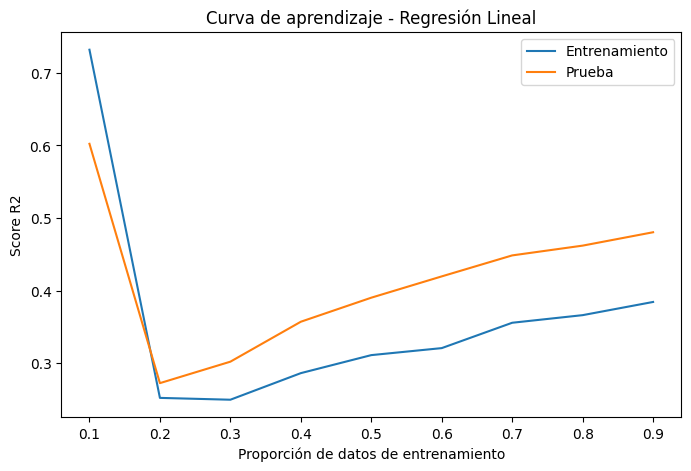

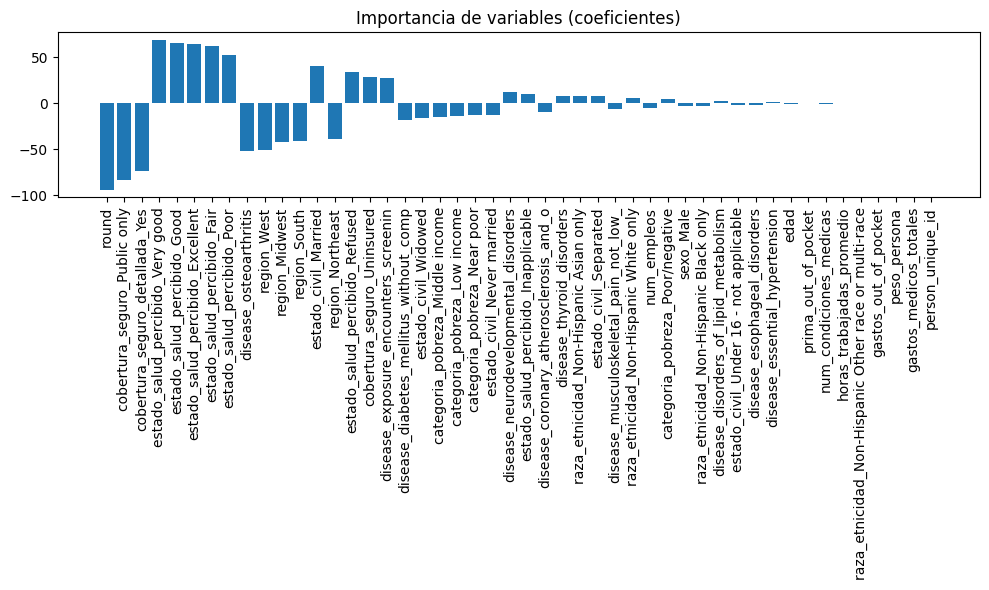

Modelo guardado en output/linear_regression_model.joblib


In [14]:
# Entrenamiento, evaluación y visualización del modelo
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Entrenar el modelo
print("Entrenando el modelo de Regresión Lineal...")
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predicciones
print("Realizando predicciones...")
y_pred = lr.predict(X_test)

# Evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# Curva de aprendizaje
train_scores = []
test_scores = []
sizes = np.linspace(0.1, 0.9, 9)
for size in sizes:
    X_train_part, _, y_train_part, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    lr_part = LinearRegression()
    lr_part.fit(X_train_part, y_train_part)
    train_scores.append(lr_part.score(X_train_part, y_train_part))
    test_scores.append(lr_part.score(X_test, y_test))

plt.figure(figsize=(8,5))
plt.plot(sizes, train_scores, label='Entrenamiento')
plt.plot(sizes, test_scores, label='Prueba')
plt.xlabel('Proporción de datos de entrenamiento')
plt.ylabel('Score R2')
plt.title('Curva de aprendizaje - Regresión Lineal')
plt.legend()
plt.show()

# Importancia de variables (coeficientes)
coeficientes = lr.coef_
indices = np.argsort(np.abs(coeficientes))[::-1]
plt.figure(figsize=(10,6))
plt.title('Importancia de variables (coeficientes)')
plt.bar(range(X.shape[1]), coeficientes[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Guardar el modelo
joblib.dump(lr, 'output/linear_regression_model.joblib')
print("Modelo guardado en output/linear_regression_model.joblib")

In [15]:
# Búsqueda de hiperparámetros: Regresión Ridge y Lasso
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

print("Iniciando búsqueda de hiperparámetros...")

# Escalar variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regresión Ridge
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge = Ridge()
gs_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
gs_ridge.fit(X_train_scaled, y_train)
print(f'Mejor alpha para Ridge: {gs_ridge.best_params_}')
print(f'Error cuadrático medio (RMSE) para Ridge: {np.sqrt(-gs_ridge.best_score_):.2f}')

# Regresión Lasso
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso = Lasso(max_iter=10000)
gs_lasso = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
gs_lasso.fit(X_train_scaled, y_train)
print(f'Mejor alpha para Lasso: {gs_lasso.best_params_}')
print(f'Error cuadrático medio (RMSE) para Lasso: {np.sqrt(-gs_lasso.best_score_):.2f}')

# Guardar el mejor modelo
joblib.dump(gs_lasso.best_estimator_, 'output/linear_regression_best_model.joblib')
print("Mejor modelo guardado en output/linear_regression_best_model.joblib")

# Resumen de mejores hiperparámetros
print("\nResumen de mejores hiperparámetros:")
print(f"Ridge: {gs_ridge.best_params_}")
print(f"Lasso: {gs_lasso.best_params_}")

# Evaluación general del modelo
if abs(gs_ridge.best_score_ - gs_lasso.best_score_) < 0.01:
    print("Ambos modelos tienen un desempeño similar según el RMSE promedio de validación cruzada.")
else:
    print("Existe una diferencia notable en el desempeño entre Ridge y Lasso.")

# Detección de overfitting/underfitting
if gs_ridge.best_score_ > -1 and gs_lasso.best_score_ > -1:
    print("Advertencia: Los errores de validación cruzada son muy bajos, podría haber overfitting.")
elif gs_ridge.best_score_ < -1000 or gs_lasso.best_score_ < -1000:
    print("Advertencia: Los errores de validación cruzada son muy altos, posible underfitting o mala calidad de datos.")
else:
    print("Los modelos presentan un desempeño razonable según las métricas de validación cruzada.")

Iniciando búsqueda de hiperparámetros...
Mejor alpha para Ridge: {'alpha': 100}
Error cuadrático medio (RMSE) para Ridge: 320.11


c:\Users\DJSix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.562e+05, tolerance: 8.613e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\DJSix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.995e+05, tolerance: 8.309e+04
  model = cd_fast.enet_coordinate_descent(
c:\Users\DJSix\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

Mejor alpha para Lasso: {'alpha': 100}
Error cuadrático medio (RMSE) para Lasso: 299.50
Mejor modelo guardado en output/linear_regression_best_model.joblib

Resumen de mejores hiperparámetros:
Ridge: {'alpha': 100}
Lasso: {'alpha': 100}
Existe una diferencia notable en el desempeño entre Ridge y Lasso.
Advertencia: Los errores de validación cruzada son muy altos, posible underfitting o mala calidad de datos.
